In [1]:
import multiprocessing as mp  
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from ipywidgets import interact, fixed, DatePicker
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import xarray as xr
from dask.diagnostics import ProgressBar
#from mpl_toolkits.basemap import Basemap

In [2]:
ESDC = xr.open_zarr('/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.25deg-184x90x90-2.0.0.zarr', auto_chunk = True)

In [3]:
ESDC

<xarray.Dataset>
Dimensions:                            (bnds: 2, lat: 720, lon: 1440, time: 1702)
Coordinates:
  * lat                                (lat) float32 89.875 89.625 ... -89.875
    lat_bnds                           (lat, bnds) float32 dask.array<shape=(720, 2), chunksize=(90, 2)>
  * lon                                (lon) float32 -179.875 ... 179.875
    lon_bnds                           (lon, bnds) float32 dask.array<shape=(1440, 2), chunksize=(90, 2)>
  * time                               (time) datetime64[ns] 1980-01-05 ... 2016-12-30
    time_bnds                          (time, bnds) datetime64[ns] dask.array<shape=(1702, 2), chunksize=(184, 2)>
Dimensions without coordinates: bnds
Data variables:
    Rg                                 (time, lat, lon) float32 dask.array<shape=(1702, 720, 1440), chunksize=(184, 90, 90)>
    aerosol_optical_thickness_1600     (time, lat, lon) float32 dask.array<shape=(1702, 720, 1440), chunksize=(184, 90, 90)>
    aerosol_optical

In [4]:
# Create a variable 'vars_monthly', and save temporally resampled (to monthly) data to the variable
vars_monthly = {'mask': ESDC['mask'].sel(time='2010-01-01',method='nearest'),
                'fapar': ESDC['fapar_tip'].resample(time = '1M',keep_attrs = True).mean('time', skipna = True),
                'soil_moisture': ESDC['soil_moisture'].resample(time = '1M',keep_attrs = True).mean(dim = 'time', skipna = True),
                'precipitation': ESDC['precipitation'].resample(time = '1M',keep_attrs = True).sum('time'),
                'pevapotranspiration': ESDC['potential_evaporation'].resample(time = '1M',keep_attrs = True).sum('time') + ESDC['transpiration'].resample(time = '1M',keep_attrs = True).sum('time')}

In [5]:
# Calculate alpha and beta variables to fit gamma distribution. Also, calculate probabilty of zero in the time series.

def spi_gamma_params(data_monthly,spi_window,dtype):
    
# Select data for calibration and analysis periods. As the data span is low for PE and T, select same 10-year window for both.
    start_calib = pd.to_datetime('2004-01-31')
    end_calib = pd.to_datetime('2013-12-31')
    
    start_analysis = '2004-01-31'
    end_analysis = '2013-12-31'
    
# For some reason, rolling method crashes, for long timespans. Hence, shorten the timespan for the raw data.
    slice_for_rolling_start = '2002-12-31'
    slice_for_rolling_end = '2015-01-01'
    data_monthly = data_monthly.loc[dict(time=slice(slice_for_rolling_start, slice_for_rolling_end))]

    print(dtype+' calculating rolling sum with '+str(spi_window)+'-month running window')
    
# If the european spatial subset is not used, calculate the rolling sum for eastern and western parts of the globe separately.
    if 'euro' not in dtype:
        data_monhtly_east = data_monthly.sel(lon = slice(0,180))
        data_monthly_west = data_monthly.sel(lon = slice(-180.,0))
        data_window_east = data_monhtly_east.rolling(time=spi_window ,center=False).sum()
        print(dtype+' east')
        data_window_west = data_monthly_west.rolling(time=spi_window ,center=False).sum()
        print(dtype+' west')
        data_window = xr.concat((data_window_west,data_window_east),dim = 'lon')
        print(data_window)
        
        
    elif 'euro' in dtype:
        data_window = data_monthly.rolling(time=spi_window ,center=False).sum()

# Select the time slice, as defined above.
    data_window_analysis = data_window.loc[dict(time=slice(start_analysis, end_analysis))]
    data_window = data_window.loc[dict(time=slice(start_calib, end_calib))]
                 
    #print(data_window.shape)
    #plt.imshow(data_window[7,:,:])
    #plt.colorbar()
    #plt.show()


    print(dtype+' calculating parameters for gamma distribution')
    
# Calculate parameters for SPI and SPEI following https://www.drought.gov/drought/climate-and-drought-indices-python
# Calculate likelihood of zero
    zeros_N = (data_window == 0).groupby('time.month').sum('time')
    zeros_P = zeros_N / (data_window.sizes['time']/12.0)
# Change values <= zero to NaN
    data_window = data_window.where(data_window > 0)
    
# Calculate the mean for each month.
    data_window_monthly_mean = data_window.groupby('time.month').mean(dim='time', skipna = True)
# Log-transform for monthly means.
    data_window_monthly_mean_log = xr.apply_ufunc(np.log, data_window_monthly_mean, dask = 'allowed')
    
# Log-transform the data.
    data_window_log = xr.apply_ufunc(np.log, data_window, dask = 'allowed')
# Calculate the mean of the log-transformed values.
    data_window_log_monthly_mean = data_window_log.groupby('time.month').mean(dim='time', skipna = True)
    
# Calculate A, alpha and beta, again following https://www.drought.gov/drought/climate-and-drought-indices-python
    A = data_window_monthly_mean_log - data_window_log_monthly_mean    
    alphas = (1 + xr.apply_ufunc(np.sqrt,(1 + 4 * A / 3), dask = 'allowed')) / (4 * A)
    betas = data_window_monthly_mean / alphas

    return alphas.values, betas.values, zeros_P.values, data_window_analysis


In [6]:
def spi_fit_gamma_distribution(array,alpha,beta):

    prob_lon = np.zeros(array.shape)

# For each cell, fit a gamma distribtion, based on the alpha and beta values.
# If all values in the a cell are NaN, skip those cells.
    for lon in range(0,array.shape[1]):
        if np.isnan(array[:,lon]).all():
            prob_lon[:,lon] = np.nan
        else:
            prob_lon[:,lon] = scipy.stats.gamma.cdf(array[:,lon],a = alpha[lon],scale = beta[lon])
            
    return prob_lon

In [7]:
def spi_calculate(data_monthly,spi_window,dtype):
    time_st = time.time()
    
# Based on 'dtype' parameter, select the appropriate information from data_monthly (either SPI or SPEI here).
    if 'spei' in dtype:
        # Add 100, to the (p - pet), to avoid below zero values, similarly to https://www.drought.gov/drought/climate-and-drought-indices-python
        p_monthly = data_monthly['precipitation']
        pet_monthly = data_monthly['pevapotranspiration']
        data_monthly = p_monthly - pet_monthly + 100
    elif 'spi' in dtype:
        data_monthly = data_monthly['precipitation']

# Select europe from the data (for testing purposes).
    if 'euro' in dtype:
        data_monthly = data_monthly.sel(lat = slice(70.,30.), lon = slice(-20.,35.))
    
# Rechunk data, so that it's possible to use the rolling function.
    data_monthly = data_monthly.chunk({'lat': 10, 'lon': 10, 'time': data_monthly.sizes['time']})
    
# Get parameters for gamma distribution.
    alphas, betas, zeros_P, data_window = spi_gamma_params(data_monthly,spi_window,dtype)
    probability = np.zeros((data_window.sizes['time'],data_window.sizes['lat'],data_window.sizes['lon']))
        
    print(str(time.time()-time_st)+' seconds passed - entering loop going through each month')# \nMonth number :')
    
# Fit gamma distribution for each month, latitude and longitude separately.
    for month in range(1,13):
        #print(month)
# Select the monthly values.
        month_boolean = data_window['time.month'] == month
        data_window_month_np = data_window[month_boolean,:,:].values
        alpha_monthly = alphas[month-1,:,:]
        beta_monthly = betas[month-1,:,:]
        
        for lat in range(0,data_window.sizes['lat']):
            data_window_month_lat = data_window_month_np[:,lat,:]
            alpha = alpha_monthly[lat,:]
            beta = beta_monthly[lat,:]
# Obtain probabilities by fitting to gamma distribution.
            probability_temp = spi_fit_gamma_distribution(data_window_month_lat,alpha,beta)
            probability[month_boolean,lat,:] = probability_temp
# Account for zero probability.
        zeros_P_month = zeros_P[month-1,:,:]
        probability[month_boolean,:,:] =  zeros_P_month + ((1 - zeros_P_month) * probability[month_boolean])

# Probabilities to normal distribution standard deviations.
    index = scipy.stats.norm.ppf(probability)
    
# Create a xarray DataArray from the numpy array.
    data_xarray = xr.DataArray(index,
                               dims = ('time','lat','lon'),
                               coords = {'time': data_window['time'].values,
                                       'lat': data_window['lat'].values,
                                       'lon': data_window['lon'].values,
                                       })
# Mask land and save as netcdf
    data_xarray = data_xarray.where(vars_monthly['mask']==2)
    data_xarray.to_netcdf(dtype+'.nc')
    
    print(str(time.time()-time_st)+' seconds passed for whole show - thank you!')
    
    #return index

In [8]:
def anom_calculate(data_monthly,dtype):
    
# Select europe from the data (for testing purposes).
    if 'euro' in dtype:
        data_monthly = data_monthly.sel(lat = slice(70.,30.), lon = slice(-20.,35.))
    
# Rechunk data.
    data_monthly = data_monthly.chunk({'lat': data_monthly.sizes['lat'], 'lon': data_monthly.sizes['lon'], 'time': 1})
# Interpolate data to get coverage for the whole world.
# Interpolation conducted by first interpolating along latitude and then longitude (not an optimal, but could not find a better way to do it using xarray).
    data_monthly = data_monthly.interpolate_na(dim = 'lon', method='linear')
    data_monthly = data_monthly.isel(lat=slice(None, None, -1)).interpolate_na(dim = 'lat', method='linear').isel(lat=slice(None, None, -1))

# Select data for calibration and analysis periods. As the data span is low for PE and T, select same 10-year window for both.
    start_calib = '2004-01-31'
    end_calib = '2013-12-31'
    start_analysis = '2004-01-31'
    end_analysis = '2013-12-31'
    
    data_analysis = data_monthly.loc[dict(time=slice(start_analysis, end_analysis))]
    data = data_monthly.loc[dict(time=slice(start_calib, end_calib))]
    
# Calculate the monthly z-score anomaly.
    mean_month = data.groupby('time.month').mean('time')
    std_month = data.groupby('time.month').std('time')
    monthly_zscore = xr.apply_ufunc(lambda val, mean, std: (val - mean)/std, data_analysis.groupby('time.month'), mean_month, std_month, dask='allowed')
    
# Mask land data.
    monthly_zscore = monthly_zscore.where(vars_monthly['mask']==2)
    
# Save into netcdf.
    monthly_zscore.to_netcdf(dtype+'.nc')
    

In [9]:
# Calculate 3-month and 12-month SPI and SPEI by
# Parallelize into four cores.
# Save the indices as netcdf files.

pool = mp.Pool(processes = 4)
p = pool.starmap(spi_calculate,[(vars_monthly, 3, 'spi_3_month'),
                                (vars_monthly, 3,'spei_3_month'),
                                (vars_monthly, 12,'spi_12_month'),
                                (vars_monthly,12,'spei_12_month')])
pool.close()

In [10]:
# Calculate drought indices for soil moisture and fapar, based on the functions described above.
# Save the calculations as netcdf files.

anom_calculate(vars_monthly['soil_moisture'],'soil_moisture_anom')
anom_calculate(vars_monthly['fapar'],'fapar_anom')

In [10]:
# Below this cell, only additional visualizationd and checks etc..

In [ ]:
filename = 'spi_3_month.nc'
drought_index = xr.open_dataarray(filename)
print(drought_index)

def plot_image(ds,time_index='2009-11-08'):
    #fig = plt.figure()
    ccmap = plt.cm.jet_r
    vmin = -3.19
    vmax = 3.19
    ds = ds.sel(time=time_index,method='nearest').plot(vmin = vmin, vmax = vmax, cmap = ccmap)

    #ds = ds[time_index,:,:]
    #im = plt.imshow(ds,cmap=ccmap,vmin = vmin, vmax=vmax)
    #cb = plt.colorbar()

date = DatePicker(
    description='Pick a Date',
    disabled=False
)

interact(plot_image, ds = fixed(drought_index), time_index=date)

<xarray.DataArray (time: 120, lat: 720, lon: 1440)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 1.607234,  1.607234, ...,  1.608042,  1.608042],
        [ 1.607234,  1.607234, ...,  1.608042,  1.608042]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 1.265896,  1.265896, ...,  1.267162,  1.267162],
        [ 1.265896,  1.265896, ...,  1.267162,  1.267162]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.605662, -0.605662, ..., -0.605815, -0.605815],
        [-0.605662, -0.605662, ..., -0.605815, -0.605815]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.753407, -0.753407, ..., -0.753223, -0.7

interactive(children=(DatePicker(value=None, description='Pick a Date'), Output()), _dom_classes=('widget-inte…

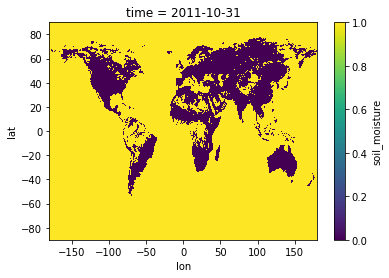

In [19]:
xr.apply_ufunc(np.isnan, vars_monthly['soil_moisture'], dask = 'allowed').sel(time='2011-11-01',method='nearest').plot()

In [ ]:
vars_monthly['soil_moisture'] = vars_monthly['soil_moisture'].chunk({'lat': vars_monthly['soil_moisture'].sizes['lat'], 'lon': vars_monthly['soil_moisture'].sizes['lon'], 'time': 1})

vars_monthly['soil_moisture'].interpolate_na(dim = 'lon', method='linear').where(vars_monthly['mask']==2).sel(time='2003-12-01',method='nearest').plot()

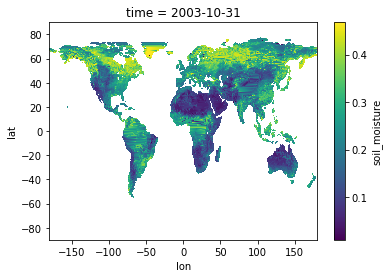

In [26]:
vars_monthly['soil_moisture'] = vars_monthly['soil_moisture'].chunk({'lat': vars_monthly['soil_moisture'].sizes['lat'], 'lon': vars_monthly['soil_moisture'].sizes['lon'], 'time': 1})
vars_monthly['soil_moisture'].interpolate_na(dim = 'lon', method='linear').where(vars_monthly['mask']==2).sel(time='2003-11-01',method='nearest').plot()
#A = vars_monthly['soil_moisture'].fillna(0).interp(lon=lon, lat=lat, method = 'nearest')

In [22]:
vars_monthly['fapar'] = vars_monthly['fapar'].chunk({'lat': vars_monthly['fapar'].sizes['lat'], 'lon': vars_monthly['fapar'].sizes['lon'], 'time': 1})

vars_monthly['fapar'].interpolate_na(dim = 'lon', method='linear').where(vars_monthly['mask']==2).sel(time='2003-11-01',method='nearest').plot()